[Need to add more mathematics]

The problem: Out of the 18 dataset classes, the NN model only uses a subset to label pixels. This file will explain an algorithm to map the model's predictions to the dataset's original classes.

In our case, the dataset has two categories of classes: What is outside the billboards and what is inside the billboards. Only the class 'Outside Billboard' is in the category 'What is outside the billboards', and the other classes ('Billboard', 'Field player', 'Goalkeeper'...) are in the category 'What is inside the billboards'. The dataset classes not used by the model are labelled as 'Outside Billboard' in the predictions.

The model uses at least two classes: 'Outside Billboard' and 'Billboard'. Let's assume the model is 100% correct. Then, the prediction pixels inside the billboards are labelled as 'Outside Billboard' if they are a dataset class not used by the model. Those pixels are called 'unlabelled pixels'.

The classes the unlabelled pixels will be mapped to are the dataset classes minus the model classes. Those classes are called mapping classes. The mapping is done as follows: each unlabelled pixel is mapped to the class of the closest ground truth pixel labelled with a class from the mapping classes.

Because the model is not ideal, we must first extract the unlabelled pixels before mapping.

For the algorithm to work, we assume the model can ideally separate outside billboard pixels from inside billboard pixels, or else there will be ambiguity around the 'outside billboard' prediction pixels: Did the model use this label because it is a pixel outside the billboard or a pixel inside the billboard but of a class not recognized by the model?

Then, the pixels inside the billboard labelled as 'Outside billboard' in the prediction are either unlabelled pixels or pixels mistakenly not recognized by the model as pixels inside the billboard. Those pixels are called 'Inside Outside billboard' pixels, or 'IOB' pixels. The second assumption is as follows:

Let unlabelled be a binary image with the exact dimensions as the dataset images, where the pixel is one if it is an IOB pixel. Then, the unlabelled pixels are those in 4-connected components containing mapping class labelled pixels in the ground truth.

In [210]:
from torch.nn.functional import one_hot, conv2d
import torch
import numpy as np
from cv2 import distanceTransform, DIST_L2, DIST_MASK_PRECISE

import matplotlib.pyplot as plt

In [211]:
nclasses = 18  # Number of dataset classes
model_classes = [0,1,4]  # Classes used for training the model
dataset_classes = [i for i in range(nclasses)]  # Classes in the dataset
mapping_classes = [i for i in dataset_classes if i not in model_classes]  # Classes to map model class 0 to

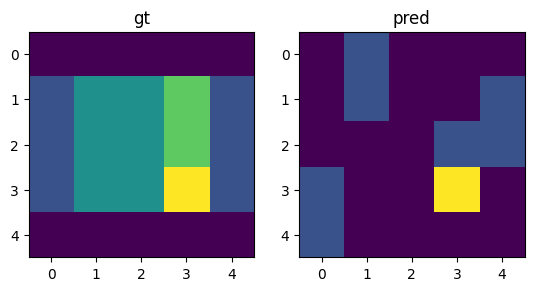

In [212]:
# Exemple of ground truth and prediction
gt = torch.tensor([[0,0,0,0,0],[1,2,2,3,1],[1,2,2,3,1],[1,2,2,4,1],[0,0,0,0,0],], dtype=torch.int64)
pred = torch.tensor([[0,1,0,0,0],[0,1,0,0,1],[0,0,0,1,1],[1,0,0,4,0],[1,0,0,0,0],], dtype=torch.int64)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(gt.numpy())
plt.title('gt')
plt.subplot(1, 2, 2)
plt.imshow(pred.numpy())
plt.title('pred')
plt.show()

### Compute IOB binary image

In [213]:
# Convert the ground truth and prediction to class binary images (cbimages), i.e. one image per class with 1 where the class is present and 0 elsewhere
gt_cbimages = one_hot(gt, nclasses).permute(2, 0, 1)
pred_cbimages = one_hot(pred, nclasses).permute(2, 0, 1)
print('gt_cbimages')
print(gt_cbimages)
print('pred_cbimages')
print(pred_cbimages)
# Shape is (nclasses, height, width)
print('gt_cbimages.shape')
print(gt_cbimages.shape)
print('pred_cbimages.shape')
print(pred_cbimages.shape)

gt_cbimages
tensor([[[1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1]],

        [[0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1],
         [1, 0, 0, 0, 1],
         [1, 0, 0, 0, 1],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0,

In [214]:
IOB_cbimage = pred_cbimages[0].sub(gt_cbimages[0]).clamp(0, 1)
# May be faster if we do 
# IOB_cbimage = torch.logical_and(pred_cbimages[0], torch.logical_not(gt_cbimages[0])).int()
# Or if we do
# IOB_cbimage = pred_cbimages[0].masked_fill_(gt_cbimages[0].bool(), 0)
# Or by using masked tensors
# To test on cpu and gpu
print('IOB_cbimage')
print(IOB_cbimage)

IOB_cbimage
tensor([[0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0],
        [1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0]])


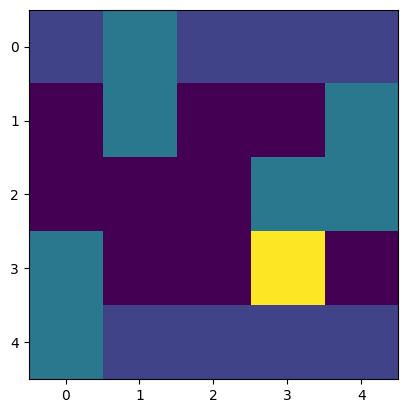

In [215]:
fig = torch.cat((IOB_cbimage.unsqueeze(0), pred_cbimages), dim=0).permute(1, 2, 0).argmax(dim=2).numpy()
plt.figure()
plt.imshow(fig)

### Compute unlabelled pixels

It is easy to compute the unlabelled pixels with a distance of 0 to a mapping class labelled ground truth pixel. Let unlabelled be the binary image of those pixels. Suppose we dilate a maximum unlabelled on the neighbouring IOB pixels. In that case, the IOB pixels covered by the dilation are the unlabelled pixels since they are connected to mapping class labelled ground truth pixels.

In [216]:
mapping_class_labelled_pixels_mask = torch.zeros_like(IOB_cbimage)
for c in mapping_classes:
    mapping_class_labelled_pixels_mask = torch.logical_or(mapping_class_labelled_pixels_mask, gt_cbimages[c])
print('mapping_class_labelled_pixels_mask')
print(mapping_class_labelled_pixels_mask)

mapping_class_labelled_pixels_mask
tensor([[False, False, False, False, False],
        [False,  True,  True,  True, False],
        [False,  True,  True,  True, False],
        [False,  True,  True, False, False],
        [False, False, False, False, False]])


In [217]:
unlabelled = torch.logical_and(IOB_cbimage, mapping_class_labelled_pixels_mask)
print('unlabelled')
print(unlabelled)

unlabelled
tensor([[False, False, False, False, False],
        [False, False,  True,  True, False],
        [False,  True,  True, False, False],
        [False,  True,  True, False, False],
        [False, False, False, False, False]])


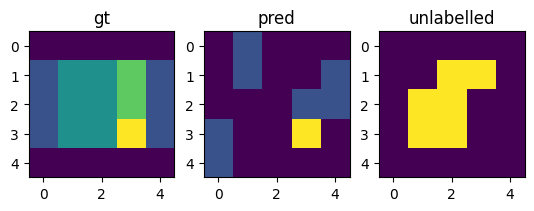

In [218]:
# Plot side by side gt, pred and unlabelled
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(gt.numpy())
plt.title('gt')
plt.subplot(1, 3, 2)
plt.imshow(pred.numpy())
plt.title('pred')
plt.subplot(1, 3, 3)
plt.imshow(unlabelled.numpy())
plt.title('unlabelled')
plt.show()

In [219]:
kernel = torch.tensor([[[0, 0, 0], 
                        [0, -10, 0], 
                        [0, 0, 0]],
                        
                       [[0, 1, 0], 
                        [1, 1, 1], 
                        [0, 1, 0]]], dtype=torch.int64).unsqueeze(0)

In [220]:
dil = torch.cat(((1 - IOB_cbimage).unsqueeze(0), unlabelled.unsqueeze(0)), dim=0)
print('dil')
print(dil)

dil
tensor([[[1, 1, 1, 1, 1],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 1, 0],
         [1, 1, 1, 1, 1]],

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]]])


In [221]:
prev_dil = dil.clone()
prev_dil[1,0,0] = 1 - prev_dil[1,0,0]  # To make sure the while loop runs at least once
prev_dil

tensor([[[1, 1, 1, 1, 1],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 1, 0],
         [1, 1, 1, 1, 1]],

        [[1, 0, 0, 0, 0],
         [0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]]])

In [222]:
while not torch.equal(dil, prev_dil):
    prev_dil[1] = dil[1].clone()
    dil[1] = conv2d(dil, kernel, padding='same').clamp(0, 1).squeeze(0)

In [223]:
print('dil')
print(dil)

dil
tensor([[[1, 1, 1, 1, 1],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 1, 0],
         [1, 1, 1, 1, 1]],

        [[0, 0, 0, 0, 0],
         [1, 0, 1, 1, 0],
         [1, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]]])


In [224]:
# # Or may be faster if we do
# kernel = torch.tensor([[[0, 0, 0], 
#                         [0, 10, 0], 
#                         [0, 0, 0]],
                        
#                        [[0, 1, 0], 
#                         [1, 0, 1], 
#                         [0, 1, 0]]], dtype=torch.int64).unsqueeze(0)
# dil = torch.cat((IOB_cbimage.unsqueeze(0), unlabelled.unsqueeze(0)), dim=0)
# print('dil')
# print(dil)
# prev_dil = dil.clone()
# prev_dil[1,0,0] = 1 - prev_dil[1,0,0]  # To make sure the while loop runs at least once
# print('prev_dil')
# print(prev_dil)
# while not torch.equal(dil, prev_dil):
#     prev_dil[1] = dil[1].clone()
#     dil[1] = conv2d(dil, kernel, padding='same').greater(10).long()
# print('dil')
# print(dil)

In [225]:
unlabelled = dil[1]

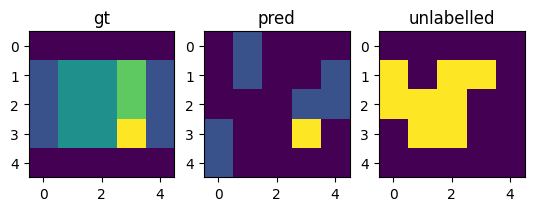

In [226]:
# Plot side by side gt, pred and unlabelled dilated
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(gt.numpy())
plt.title('gt')
plt.subplot(1, 3, 2)
plt.imshow(pred.numpy())
plt.title('pred')
plt.subplot(1, 3, 3)
plt.imshow(unlabelled.numpy())
plt.title('unlabelled')
plt.show()

### Compute distance to 0-distance mapping class labelled pixels

In [227]:
dist = gt.masked_fill(~unlabelled.bool(), 0)
dist

tensor([[0, 0, 0, 0, 0],
        [1, 0, 2, 3, 0],
        [1, 2, 2, 0, 0],
        [0, 2, 2, 0, 0],
        [0, 0, 0, 0, 0]])

Compute the set of mapping classes present in the ground truth.

In [228]:
mapping_classes_present = set(dist.unique().tolist()).intersection(mapping_classes)
mapping_classes_present

{2, 3}

In [229]:
dist = one_hot(dist, nclasses).permute(2, 0, 1).float()
dist

tensor([[[1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 1.],
         [0., 0., 0., 1., 1.],
         [1., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0

In [230]:
inf = torch.ones_like(dist[0]) * float('inf')
inf

tensor([[inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf]])

In [231]:
for c in range(nclasses):
    if c in mapping_classes_present:
        dist[c] = torch.tensor(distanceTransform(1-dist[c].to(torch.uint8).numpy(), DIST_L2, DIST_MASK_PRECISE), dtype=torch.float32)
    else:
        dist[c] = inf
dist

tensor([[[   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf]],

        [[   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf],
         [   inf,    inf,    inf,    inf,    inf]],

        [[2.2361, 1.4142, 1.0000, 1.4142, 2.2361],
         [1.4142, 1.0000, 0.0000, 1.0000, 2.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 2.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 2.0000],
         [1.4142, 1.0000, 1.0000, 1.4142, 2.2361]],

        [[3.1623, 2.2361, 1.4142, 1.0000, 1.4142],
         [3.0000, 2.0000, 1.0000, 0.0000, 1.0000],
         [3.1623, 2.2361, 1.4142, 1.0000, 1.4142],
         [3.6056, 2.8284, 2.2361, 2.0000, 2.2361],
         [4.2426, 3.6056,

In [232]:
dist = dist.permute(1, 2, 0).argmin(dim=2)
dist

tensor([[2, 2, 2, 3, 3],
        [2, 2, 2, 3, 3],
        [2, 2, 2, 2, 3],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]])

In [233]:
dist = dist.masked_fill(~unlabelled.bool(), 0)
dist

tensor([[0, 0, 0, 0, 0],
        [2, 0, 2, 3, 0],
        [2, 2, 2, 0, 0],
        [0, 2, 2, 0, 0],
        [0, 0, 0, 0, 0]])

In [234]:
pred_final = pred.masked_fill(unlabelled.bool(), 0)
pred_final

tensor([[0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1],
        [1, 0, 0, 4, 0],
        [1, 0, 0, 0, 0]])

In [235]:
pred_final.add_(dist)

tensor([[0, 1, 0, 0, 0],
        [2, 1, 2, 3, 1],
        [2, 2, 2, 1, 1],
        [1, 2, 2, 4, 0],
        [1, 0, 0, 0, 0]])

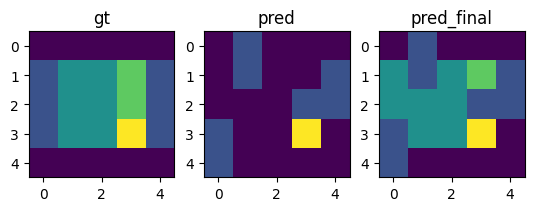

In [236]:
# Show side by side gt, pred and pred_final
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(gt.numpy())
plt.title('gt')
plt.subplot(1, 3, 2)
plt.imshow(pred.numpy())
plt.title('pred')
plt.subplot(1, 3, 3)
plt.imshow(pred_final.numpy())
plt.title('pred_final')
plt.show()